In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import numpy as np

In [4]:
!pip install pyvi
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.6 MB/s eta 0:00:00


# **1.Get data and label**

In [6]:

data_train = pd.read_csv('/content/drive/My Drive/Thesis/data/data_train.csv')
data_val = pd.read_csv('/content/drive/My Drive/Thesis/data/data_val.csv')
data_test = pd.read_csv('/content/drive/My Drive/Thesis/data/data_test.csv')

data_train.drop('Unnamed: 0', axis = 1, inplace = True)
data_val.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
data_train

,Content,quality,smell,shipping,packing,price,others,processed_content
0,chất lượng 10 điểm luôn á không mua shop nào m...,2.0,NaN,NaN,NaN,NaN,NaN,chất_lượng 10 điểm luôn á không mua shop nào m...
1,đóng gói cẩn thận giao hàng nhanh chóng dưỡng ...,2.0,NaN,2.0,2.0,NaN,NaN,đóng_gói cẩn_thận giao hàng nhanh_chóng dưỡng ...
2,dùng khá ổn da k bị căng chai nhỏ thôi nha nng,2.0,NaN,NaN,NaN,NaN,NaN,dùng khá ổn da k bị căng chai nhỏ thôi nha nng
3,bị kích ứng nỗi mụn nhiều hơn trước khi sử dụng,0.0,NaN,NaN,NaN,NaN,NaN,bị kích_ứng nỗi mụn nhiều hơn trước khi sử_dụng
4,đặt lần đầu 20 ngày vẫn ko thấy hàng hủy đặt l...,NaN,NaN,2.0,NaN,NaN,NaN,đặt lần đầu 20 ngày vẫn ko thấy hàng huỷ đặt l...
...,...,...,...,...,...,...,...,...
10570,Hầu như ai cũng biết đến em sữa rửa mặt thần t...,1.0,NaN,NaN,NaN,2.0,2.0,hầu_như ai cũng biết đến em sữa rửa mặt thần_t...
10571,da mình trộm vía xài hợp srm này tuy nhẹ nhưng...,2.0,NaN,2.0,NaN,2.0,NaN,da mình trộm_vía xài hợp srm này tuy nhẹ nhưng...
10572,"Sp tốt Tiki giao hàng rất nhanh, shipper cũng ...",2.0,NaN,2.0,NaN,NaN,2.0,sp tốt tiki giao hàng rất nhanh shipper cũng t...
10573,Da mình hay bị mụn ở vùng chữ T (da hỗn hợp th...,2.0,NaN,NaN,NaN,NaN,NaN,da mình hay bị mụn ở vùng chữ t da hỗn_hợp thi...


In [8]:
def get_aspect_label(df):
    df_aspect_label = pd.DataFrame(index=df.index, columns=['is_quality','is_smell', 'is_shipping', 'is_packing', 'is_price', 'is_others'])
    replace_dict = {np.nan: 0, 1: 1, 0: 1, 2: 1}
    df_aspect_label['is_quality'] = df['quality'].replace(replace_dict)
    df_aspect_label['is_smell'] = df['smell'].replace(replace_dict)
    df_aspect_label['is_shipping'] = df['shipping'].replace(replace_dict)
    df_aspect_label['is_packing'] = df['packing'].replace(replace_dict)
    df_aspect_label['is_price'] = df['price'].replace(replace_dict)
    df_aspect_label['is_others'] = df['others'].replace(replace_dict)
    return df_aspect_label

aspect_label_train = get_aspect_label(data_train).astype(int)
aspect_label_val = get_aspect_label(data_val).astype(int)
aspect_label_test = get_aspect_label(data_test).astype(int)

In [9]:
def get_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  content = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    content[aspect] = df_input[~df_input[f'{aspect}'].isna()].processed_content.values
  return content

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  content = get_content(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return content, sentiment_label

In [10]:
content_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
content_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
content_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

# Embbeding

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import numpy as np

df = {
    'train': data_train,
    'val': data_val,
    'test': data_test
}

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")

def process_batch(model, tokenizer, sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    return outputs.cpu().numpy()
batch_size = 200
embeddings = {}

for state in tqdm(['train']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)

np.save('/content/drive/MyDrive/Thesis/embeddings_train.npy', embeddings['train'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

100%|██████████| 1/1 [1:46:58<00:00, 6418.37s/it]


In [ ]:
for state in tqdm(['val']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)
np.save('/content/drive/MyDrive/Thesis/embeddings_val.npy', embeddings['val'])

100%|██████████| 1/1 [24:06<00:00, 1446.02s/it]


In [ ]:
df = {
    'train': data_train,
    'val': data_val,
    'test': data_test
}

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")

def process_batch(model, tokenizer, sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    return outputs.cpu().numpy()
batch_size = 200
embeddings = {}
for state in tqdm(['test']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)
np.save('/content/drive/MyDrive/Thesis/embeddings_test.npy', embeddings['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

100%|██████████| 1/1 [20:29<00:00, 1229.04s/it]


In [11]:
embeddings = {}
for state in ['train','val','test']:
  embeddings[state] = np.load(f'/content/drive/MyDrive/Thesis/embeddings_{state}.npy')


# **2.Model building**

# BILSTM

### Stage 1: Aspect detection

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh'))(input_layer)
    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(6, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

callback = EarlyStopping(monitor='val_loss', patience=5)
model_1_1 = bilstm_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

Epoch 1/200
83/83 [==============================] - 9s 33ms/step - loss: 0.5547 - accuracy: 0.5904 - val_loss: 0.4216 - val_accuracy: 0.7065
Epoch 2/200
83/83 [==============================] - 1s 12ms/step - loss: 0.3837 - accuracy: 0.6881 - val_loss: 0.3262 - val_accuracy: 0.6849
Epoch 3/200
83/83 [==============================] - 1s 10ms/step - loss: 0.3188 - accuracy: 0.6788 - val_loss: 0.2807 - val_accuracy: 0.6686
Epoch 4/200
83/83 [==============================] - 1s 11ms/step - loss: 0.2854 - accuracy: 0.6650 - val_loss: 0.2557 - val_accuracy: 0.6558
Epoch 5/200
83/83 [==============================] - 1s 11ms/step - loss: 0.2627 - accuracy: 0.6570 - val_loss: 0.2387 - val_accuracy: 0.6443
Epoch 6/200
83/83 [==============================] - 1s 11ms/step - loss: 0.2469 - accuracy: 0.6511 - val_loss: 0.2286 - val_accuracy: 0.6297
Epoch 7/200
83/83 [==============================] - 1s 10ms/step - loss: 0.2376 - accuracy: 0.6450 - val_loss: 0.2220 - val_accuracy: 0.6271
Epoch 

In [39]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_1_1.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_1_1.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_1_1.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 0s 3ms/step


In [40]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [41]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.7856135401974612, 'recall': 0.7640603566529492, 'f1-score': 0.7746870653685676, 'support': 729}, '1': {'precision': 0.889602053915276, 'recall': 0.9011703511053316, 'f1-score': 0.8953488372093023, 'support': 1538}, 'accuracy': 0.8570798411998235, 'macro avg': {'precision': 0.8376077970563687, 'recall': 0.8326153538791404, 'f1-score': 0.8350179512889349, 'support': 2267}, 'weighted avg': {'precision': 0.8561624304039012, 'recall': 0.8570798411998235, 'f1-score': 0.8565475881259782, 'support': 2267}}
is_smell
{'0': {'precision': 0.9736084452975048, 'recall': 0.9873479318734794, 'f1-score': 0.980430055568978, 'support': 2055}, '1': {'precision': 0.8579234972677595, 'recall': 0.7405660377358491, 'f1-score': 0.7949367088607594, 'support': 212}, 'accuracy': 0.9642699602999559, 'macro avg': {'precision': 0.9157659712826322, 'recall': 0.8639569848046642, 'f1-score': 0.8876833822148686, 'support': 2267}, 'weighted avg': {'precision': 0.9627900910926941, 'recall'

#### Result Stage 1

In [42]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       729
           1       0.89      0.90      0.90      1538

    accuracy                           0.86      2267
   macro avg       0.84      0.83      0.84      2267
weighted avg       0.86      0.86      0.86      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2055
           1       0.86      0.74      0.79       212

    accuracy                           0.96      2267
   macro avg       0.92      0.86      0.89      2267
weighted avg       0.96      0.96      0.96      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1504
           1       0.95      0.93      0.94       763

    accuracy                           0.96      2267
   macro avg       0.96      0.95      0.96      2267
weighted avg      

In [43]:
output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_BiLSTM.csv')

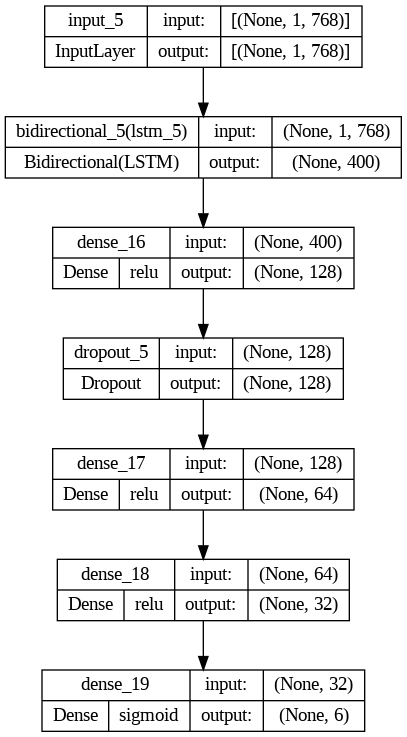

In [44]:
tf.keras.utils.plot_model(
    model_1_1, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [45]:
# plot

In [46]:
list_aspect = []
for col in aspect_label_train.columns.values:
  # if col!='is_others':
  list_aspect.append(col.split('_')[1])
list_aspect

['quality', 'smell', 'shipping', 'packing', 'price', 'others']

### Stage 2: Setiment Polarity


In [12]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

# data_train['embeddings'] = data_train['embeddings'].apply(np.array)
# data_val['embeddings'] = data_val['embeddings'].apply(np.array)
# data_test['embeddings'] = data_test['embeddings'].apply(np.array)

In [13]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [16]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [15]:
def bilstm_polarity(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):

    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)

    input_layer = Input(shape=(1, embedding_dim))
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh'))(input_layer)

    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)
    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(16, activation='relu')(aspect_dense4)
    aspect_dense6 = Dense(3, activation='sigmoid')(aspect_dense5)

    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense6)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)

    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model


In [51]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_1 = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_1[aspect] = bilstm_polarity(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----
Epoch 1/120
56/56 [==============================] - 6s 26ms/step - loss: 0.5329 - accuracy: 0.8225 - val_loss: 0.3901 - val_accuracy: 0.8187
Epoch 2/120
56/56 [==============================] - 1s 10ms/step - loss: 0.3516 - accuracy: 0.8235 - val_loss: 0.3242 - val_accuracy: 0.8187
Epoch 3/120
56/56 [==============================] - 1s 11ms/step - loss: 0.2939 - accuracy: 0.8294 - val_loss: 0.2869 - val_accuracy: 0.8353
Epoch 4/120
56/56 [==============================] - 1s 11ms/step - loss: 0.2616 - accuracy: 0.8439 - val_loss: 0.2644 - val_accuracy: 0.8373
Epoch 5/120
56/56 [==============================] - 1s 11ms/step - loss: 0.2415 - accuracy: 0.8475 - val_loss: 0.2545 - val_accuracy: 0.8340
Epoch 6/120
56/56 [==============================] - 1s 11ms/step - loss: 0.2361 - accuracy: 0.8489 - val_loss: 0.2481 - val_accuracy: 0.8393
Epoch 7/120
56/56 [==============================] - 1s 10ms/step - loss: 0.2309 - accuracy: 0.8493 - val_loss: 0.2444 - val_accura

 17%|█▋        | 1/6 [00:19<01:36, 19.24s/it]


----smell----
Epoch 1/120
8/8 [==============================] - 6s 116ms/step - loss: 0.6836 - accuracy: 0.5674 - val_loss: 0.6667 - val_accuracy: 0.7074
Epoch 2/120
8/8 [==============================] - 0s 11ms/step - loss: 0.6548 - accuracy: 0.7087 - val_loss: 0.6341 - val_accuracy: 0.7074
Epoch 3/120
8/8 [==============================] - 0s 14ms/step - loss: 0.6215 - accuracy: 0.7077 - val_loss: 0.5975 - val_accuracy: 0.7074
Epoch 4/120
8/8 [==============================] - 0s 14ms/step - loss: 0.5851 - accuracy: 0.7077 - val_loss: 0.5626 - val_accuracy: 0.7074
Epoch 5/120
8/8 [==============================] - 0s 13ms/step - loss: 0.5512 - accuracy: 0.7077 - val_loss: 0.5344 - val_accuracy: 0.7074
Epoch 6/120
8/8 [==============================] - 0s 13ms/step - loss: 0.5268 - accuracy: 0.7077 - val_loss: 0.5181 - val_accuracy: 0.7074
Epoch 7/120
8/8 [==============================] - 0s 10ms/step - loss: 0.5130 - accuracy: 0.7077 - val_loss: 0.5084 - val_accuracy: 0.7074
Epoc

 33%|███▎      | 2/6 [00:36<01:11, 17.98s/it]


----shipping----
Epoch 1/120
28/28 [==============================] - 6s 35ms/step - loss: 0.6430 - accuracy: 0.8431 - val_loss: 0.5604 - val_accuracy: 0.8669
Epoch 2/120
28/28 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.8890 - val_loss: 0.3117 - val_accuracy: 0.8669
Epoch 3/120
28/28 [==============================] - 0s 8ms/step - loss: 0.2440 - accuracy: 0.8890 - val_loss: 0.2460 - val_accuracy: 0.8669
Epoch 4/120
28/28 [==============================] - 0s 11ms/step - loss: 0.2061 - accuracy: 0.8890 - val_loss: 0.2167 - val_accuracy: 0.8669
Epoch 5/120
28/28 [==============================] - 0s 15ms/step - loss: 0.1828 - accuracy: 0.8890 - val_loss: 0.1825 - val_accuracy: 0.8669
Epoch 6/120
28/28 [==============================] - 0s 14ms/step - loss: 0.1527 - accuracy: 0.9018 - val_loss: 0.1487 - val_accuracy: 0.9302
Epoch 7/120
28/28 [==============================] - 0s 16ms/step - loss: 0.1294 - accuracy: 0.9362 - val_loss: 0.1275 - val_accurac

 50%|█████     | 3/6 [00:55<00:55, 18.48s/it]


----packing----
Epoch 1/120
30/30 [==============================] - 5s 36ms/step - loss: 0.5867 - accuracy: 0.8681 - val_loss: 0.4138 - val_accuracy: 0.8955
Epoch 2/120
30/30 [==============================] - 0s 8ms/step - loss: 0.3111 - accuracy: 0.8761 - val_loss: 0.2099 - val_accuracy: 0.8955
Epoch 3/120
30/30 [==============================] - 0s 9ms/step - loss: 0.2277 - accuracy: 0.8761 - val_loss: 0.1853 - val_accuracy: 0.8955
Epoch 4/120
30/30 [==============================] - 0s 8ms/step - loss: 0.2016 - accuracy: 0.8761 - val_loss: 0.1653 - val_accuracy: 0.8955
Epoch 5/120
30/30 [==============================] - 0s 10ms/step - loss: 0.1830 - accuracy: 0.8761 - val_loss: 0.1527 - val_accuracy: 0.8955
Epoch 6/120
30/30 [==============================] - 0s 8ms/step - loss: 0.1704 - accuracy: 0.8761 - val_loss: 0.1473 - val_accuracy: 0.8955
Epoch 7/120
30/30 [==============================] - 0s 8ms/step - loss: 0.1633 - accuracy: 0.8793 - val_loss: 0.1427 - val_accuracy: 0

 67%|██████▋   | 4/6 [01:23<00:44, 22.31s/it]


----price----
Epoch 1/120
11/11 [==============================] - 6s 84ms/step - loss: 0.6646 - accuracy: 0.7790 - val_loss: 0.6314 - val_accuracy: 0.8140
Epoch 2/120
11/11 [==============================] - 0s 9ms/step - loss: 0.5892 - accuracy: 0.8600 - val_loss: 0.5487 - val_accuracy: 0.8140
Epoch 3/120
11/11 [==============================] - 0s 9ms/step - loss: 0.4947 - accuracy: 0.8600 - val_loss: 0.4581 - val_accuracy: 0.8140
Epoch 4/120
11/11 [==============================] - 0s 10ms/step - loss: 0.3981 - accuracy: 0.8600 - val_loss: 0.3871 - val_accuracy: 0.8140
Epoch 5/120
11/11 [==============================] - 0s 10ms/step - loss: 0.3306 - accuracy: 0.8600 - val_loss: 0.3572 - val_accuracy: 0.8140
Epoch 6/120
11/11 [==============================] - 0s 12ms/step - loss: 0.3043 - accuracy: 0.8600 - val_loss: 0.3541 - val_accuracy: 0.8140
Epoch 7/120
11/11 [==============================] - 0s 10ms/step - loss: 0.2944 - accuracy: 0.8600 - val_loss: 0.3507 - val_accuracy: 

 83%|████████▎ | 5/6 [01:40<00:20, 20.32s/it]


----others----
Epoch 1/120
21/21 [==============================] - 5s 66ms/step - loss: 0.6648 - accuracy: 0.6650 - val_loss: 0.6223 - val_accuracy: 0.6933
Epoch 2/120
21/21 [==============================] - 0s 13ms/step - loss: 0.5741 - accuracy: 0.7117 - val_loss: 0.5090 - val_accuracy: 0.6933
Epoch 3/120
21/21 [==============================] - 0s 11ms/step - loss: 0.4645 - accuracy: 0.7117 - val_loss: 0.4286 - val_accuracy: 0.6933
Epoch 4/120
21/21 [==============================] - 0s 13ms/step - loss: 0.4066 - accuracy: 0.7117 - val_loss: 0.3898 - val_accuracy: 0.6933
Epoch 5/120
21/21 [==============================] - 0s 11ms/step - loss: 0.3699 - accuracy: 0.7140 - val_loss: 0.3467 - val_accuracy: 0.7005
Epoch 6/120
21/21 [==============================] - 0s 14ms/step - loss: 0.3343 - accuracy: 0.7648 - val_loss: 0.3152 - val_accuracy: 0.7967
Epoch 7/120
21/21 [==============================] - 0s 14ms/step - loss: 0.3102 - accuracy: 0.8161 - val_loss: 0.2921 - val_accurac

100%|██████████| 6/6 [01:52<00:00, 18.72s/it]


In [52]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_1[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_1[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_1[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)


19/19 [==============================] - 0s 2ms/step


In [53]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [ ]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----quality----
              precision    recall  f1-score      support   aspect
0              0.647887  0.613333  0.630137    75.000000  quality
1              0.554286  0.485000  0.517333   200.000000  quality
2              0.917957  0.939034  0.928376  1263.000000  quality
accuracy       0.864109  0.864109  0.864109     0.864109  quality
macro avg      0.706710  0.679122  0.691949  1538.000000  quality
weighted avg   0.857495  0.864109  0.860381  1538.000000  quality



----smell----
              precision    recall  f1-score     support aspect
0              0.636364  0.682927  0.658824   41.000000  smell
1              0.000000  0.000000  0.000000   17.000000  smell
2              0.851190  0.928571  0.888199  154.000000  smell
accuracy       0.806604  0.806604  0.806604    0.806604  smell
macro avg      0.495851  0.537166  0.515674  212.000000  smell
weighted avg   0.741388  0.806604  0.772615  212.000000  smell



----shipping----
              precision    recall  f1-score

In [ ]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_BiLSTM.csv')

# BiLSTM + Conv1D



### Stage 1: Aspect detection

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def bilstm_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))


    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)


    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.3)(batch_norm1)

    dense2 = Dense(64, activation='relu')(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.3)(batch_norm2)

    dense3 = Dense(32, activation='relu')(dropout2)
    output_layer = Dense(6, activation='sigmoid')(dense3)


    aspect_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    callback_list = [early_stopping, reduce_lr]
    if callbacks:
        callback_list.extend(callbacks)


    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callback_list,
                               verbose=verbose)

    return aspect_model, history


embedding_dim = 768

padded_aspect_train = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
padded_aspect_val = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

sequence_length = padded_aspect_train.shape[1]

model_2, _ = bilstm_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=None, verbose=1)


Epoch 1/200
83/83 [==============================] - 11s 43ms/step - loss: 0.5313 - accuracy: 0.5520 - val_loss: 0.6424 - val_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 2/200
83/83 [==============================] - 1s 14ms/step - loss: 0.4089 - accuracy: 0.6182 - val_loss: 0.5891 - val_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 3/200
83/83 [==============================] - 1s 14ms/step - loss: 0.3561 - accuracy: 0.6221 - val_loss: 0.5494 - val_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 4/200
83/83 [==============================] - 1s 14ms/step - loss: 0.3209 - accuracy: 0.6314 - val_loss: 0.5036 - val_accuracy: 0.6743 - lr: 1.0000e-04
Epoch 5/200
83/83 [==============================] - 1s 14ms/step - loss: 0.3009 - accuracy: 0.6342 - val_loss: 0.4447 - val_accuracy: 0.6937 - lr: 1.0000e-04
Epoch 6/200
83/83 [==============================] - 1s 15ms/step - loss: 0.2813 - accuracy: 0.6369 - val_loss: 0.3794 - val_accuracy: 0.7520 - lr: 1.0000e-04
Epoch 7/200
83/83 [==========================

In [55]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_2.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_2.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_2.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 0s 3ms/step


In [56]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [57]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.7855113636363636, 'recall': 0.7585733882030178, 'f1-score': 0.7718073970690859, 'support': 729}, '1': {'precision': 0.8873960332693538, 'recall': 0.9018205461638491, 'f1-score': 0.8945501451144792, 'support': 1538}, 'accuracy': 0.8557565063961182, 'macro avg': {'precision': 0.8364536984528588, 'recall': 0.8301969671834335, 'f1-score': 0.8331787710917825, 'support': 2267}, 'weighted avg': {'precision': 0.8546329436520403, 'recall': 0.8557565063961182, 'f1-score': 0.8550797157694895, 'support': 2267}}
is_smell
{'0': {'precision': 0.9672209026128266, 'recall': 0.9907542579075426, 'f1-score': 0.9788461538461538, 'support': 2055}, '1': {'precision': 0.8827160493827161, 'recall': 0.6745283018867925, 'f1-score': 0.7647058823529412, 'support': 212}, 'accuracy': 0.9611821790913101, 'macro avg': {'precision': 0.9249684759977713, 'recall': 0.8326412798971675, 'f1-score': 0.8717760180995475, 'support': 2267}, 'weighted avg': {'precision': 0.9593183755352863, 'recal

#### Result Stage 1

In [58]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       729
           1       0.89      0.90      0.89      1538

    accuracy                           0.86      2267
   macro avg       0.84      0.83      0.83      2267
weighted avg       0.85      0.86      0.86      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2055
           1       0.88      0.67      0.76       212

    accuracy                           0.96      2267
   macro avg       0.92      0.83      0.87      2267
weighted avg       0.96      0.96      0.96      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1504
           1       0.95      0.94      0.95       763

    accuracy                           0.96      2267
   macro avg       0.96      0.96      0.96      2267
weighted avg      

In [59]:
output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_BiLSTM_Conv.csv')

### Stage 2: Sentiment Polarity

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def bilstm_conv_sentiment(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))


    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)


    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.3)(batch_norm1)

    dense2 = Dense(64, activation='relu')(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.3)(batch_norm2)

    dense3 = Dense(32, activation='relu')(dropout2)
    output_layer = Dense(3, activation='sigmoid')(dense3)


    aspect_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    callback_list = [early_stopping, reduce_lr]
    if callbacks:
        callback_list.extend(callbacks)


    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callback_list,
                               verbose=verbose)
    return aspect_model, history
embedding_dim = 768
padded_aspect_train = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
padded_aspect_val = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

In [23]:
list_aspect = data_train.columns[1:-2]
list_aspect

Index(['quality', 'smell', 'shipping', 'packing', 'price', 'others'], dtype='object')

In [24]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_2 = {}

# Loop over each aspect to train the TCN model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Ensure data is stacked and reshaped correctly
    # padded_aspect_train = np.array(embeddings_train[aspect])
    # padded_aspect_val = np.array(embeddings_val[aspect])

    padded_aspect_train = np.stack(embeddings_train[aspect]).reshape((-1, np.stack(embeddings_train[aspect]).shape[1] // embedding_dim, embedding_dim))
    padded_aspect_val = np.stack(embeddings_val[aspect]).reshape((-1,np.stack(embeddings_val[aspect]).shape[1] // embedding_dim, embedding_dim))

    # Determine sequence length and embedding dimension
    sequence_length = padded_aspect_train.shape[1]
    embedding_dim = 768

    # Train the model for the current aspect
    sentiment_model_2[aspect] = bilstm_conv_sentiment(
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
        padded_aspect_train=padded_aspect_train,
        padded_aspect_val=padded_aspect_val,
        label_aspect_train=np.array(sentiment_label_train[aspect]),
        label_aspect_val=np.array(sentiment_label_val[aspect]),
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )
    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----
Epoch 1/120
56/56 [==============================] - 15s 103ms/step - loss: 0.4414 - accuracy: 0.7293 - val_loss: 0.6572 - val_accuracy: 0.8187 - lr: 1.0000e-04
Epoch 2/120
56/56 [==============================] - 3s 47ms/step - loss: 0.3317 - accuracy: 0.8166 - val_loss: 0.6417 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 3/120
56/56 [==============================] - 4s 67ms/step - loss: 0.2985 - accuracy: 0.8343 - val_loss: 0.6199 - val_accuracy: 0.8347 - lr: 1.0000e-04
Epoch 4/120
56/56 [==============================] - 4s 71ms/step - loss: 0.2758 - accuracy: 0.8473 - val_loss: 0.5281 - val_accuracy: 0.8293 - lr: 1.0000e-04
Epoch 5/120
56/56 [==============================] - 3s 51ms/step - loss: 0.2597 - accuracy: 0.8543 - val_loss: 0.4365 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 6/120
56/56 [==============================] - 3s 49ms/step - loss: 0.2465 - accuracy: 0.8561 - val_loss: 0.3549 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 7/120
56/56 [========

 17%|█▋        | 1/6 [01:10<05:51, 70.38s/it]


----smell----
Epoch 1/120
8/8 [==============================] - 11s 226ms/step - loss: 0.8704 - accuracy: 0.2406 - val_loss: 0.6866 - val_accuracy: 0.1064 - lr: 1.0000e-04
Epoch 2/120
8/8 [==============================] - 0s 56ms/step - loss: 0.7784 - accuracy: 0.3441 - val_loss: 0.6805 - val_accuracy: 0.1064 - lr: 1.0000e-04
Epoch 3/120
8/8 [==============================] - 0s 54ms/step - loss: 0.7031 - accuracy: 0.3959 - val_loss: 0.6738 - val_accuracy: 0.1702 - lr: 1.0000e-04
Epoch 4/120
8/8 [==============================] - 0s 54ms/step - loss: 0.6652 - accuracy: 0.4628 - val_loss: 0.6660 - val_accuracy: 0.7021 - lr: 1.0000e-04
Epoch 5/120
8/8 [==============================] - 0s 49ms/step - loss: 0.6335 - accuracy: 0.4876 - val_loss: 0.6574 - val_accuracy: 0.7074 - lr: 1.0000e-04
Epoch 6/120
8/8 [==============================] - 0s 48ms/step - loss: 0.6157 - accuracy: 0.5070 - val_loss: 0.6493 - val_accuracy: 0.7074 - lr: 1.0000e-04
Epoch 7/120
8/8 [========================

 33%|███▎      | 2/6 [02:08<04:11, 62.87s/it]


----shipping----
Epoch 1/120
28/28 [==============================] - 11s 110ms/step - loss: 0.7856 - accuracy: 0.3468 - val_loss: 0.7546 - val_accuracy: 0.0168 - lr: 1.0000e-04
Epoch 2/120
28/28 [==============================] - 2s 78ms/step - loss: 0.6365 - accuracy: 0.5477 - val_loss: 0.7212 - val_accuracy: 0.0168 - lr: 1.0000e-04
Epoch 3/120
28/28 [==============================] - 2s 80ms/step - loss: 0.5507 - accuracy: 0.6751 - val_loss: 0.6951 - val_accuracy: 0.1240 - lr: 1.0000e-04
Epoch 4/120
28/28 [==============================] - 1s 48ms/step - loss: 0.4848 - accuracy: 0.7659 - val_loss: 0.6706 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 5/120
28/28 [==============================] - 1s 50ms/step - loss: 0.4391 - accuracy: 0.8292 - val_loss: 0.6280 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 6/120
28/28 [==============================] - 1s 49ms/step - loss: 0.4004 - accuracy: 0.8780 - val_loss: 0.6011 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 7/120
28/28 [=======

 50%|█████     | 3/6 [03:18<03:18, 66.28s/it]


----packing----
Epoch 1/120
30/30 [==============================] - 12s 96ms/step - loss: 0.6559 - accuracy: 0.5092 - val_loss: 0.7578 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 2/120
30/30 [==============================] - 1s 49ms/step - loss: 0.5347 - accuracy: 0.6864 - val_loss: 0.7649 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 3/120
30/30 [==============================] - 1s 49ms/step - loss: 0.4657 - accuracy: 0.7815 - val_loss: 0.7616 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 4/120
30/30 [==============================] - 2s 64ms/step - loss: 0.4140 - accuracy: 0.8423 - val_loss: 0.7571 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 5/120
30/30 [==============================] - 2s 83ms/step - loss: 0.3742 - accuracy: 0.8700 - val_loss: 0.7504 - val_accuracy: 0.0958 - lr: 1.0000e-04
Epoch 6/120
30/30 [==============================] - 2s 69ms/step - loss: 0.3389 - accuracy: 0.8969 - val_loss: 0.7238 - val_accuracy: 0.0983 - lr: 1.0000e-04
Epoch 7/120
30/30 [=========

 67%|██████▋   | 4/6 [04:06<01:58, 59.11s/it]


----price----
Epoch 1/120
11/11 [==============================] - 10s 174ms/step - loss: 0.5936 - accuracy: 0.6737 - val_loss: 0.6327 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 2/120
11/11 [==============================] - 1s 50ms/step - loss: 0.5268 - accuracy: 0.7434 - val_loss: 0.6279 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 3/120
11/11 [==============================] - 1s 51ms/step - loss: 0.4784 - accuracy: 0.7812 - val_loss: 0.6232 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 4/120
11/11 [==============================] - 1s 53ms/step - loss: 0.4377 - accuracy: 0.8085 - val_loss: 0.6179 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 5/120
11/11 [==============================] - 1s 51ms/step - loss: 0.4121 - accuracy: 0.8259 - val_loss: 0.6122 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 6/120
11/11 [==============================] - 1s 52ms/step - loss: 0.3946 - accuracy: 0.8463 - val_loss: 0.6044 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 7/120
11/11 [==========

 83%|████████▎ | 5/6 [04:33<00:47, 47.60s/it]


----others----
Epoch 1/120
21/21 [==============================] - 13s 169ms/step - loss: 1.0353 - accuracy: 0.2451 - val_loss: 0.7209 - val_accuracy: 0.0581 - lr: 1.0000e-04
Epoch 2/120
21/21 [==============================] - 1s 53ms/step - loss: 0.8570 - accuracy: 0.3992 - val_loss: 0.7111 - val_accuracy: 0.0581 - lr: 1.0000e-04
Epoch 3/120
21/21 [==============================] - 1s 48ms/step - loss: 0.7583 - accuracy: 0.5025 - val_loss: 0.7013 - val_accuracy: 0.0581 - lr: 1.0000e-04
Epoch 4/120
21/21 [==============================] - 2s 78ms/step - loss: 0.6889 - accuracy: 0.5809 - val_loss: 0.6931 - val_accuracy: 0.0599 - lr: 1.0000e-04
Epoch 5/120
21/21 [==============================] - 2s 79ms/step - loss: 0.6336 - accuracy: 0.6256 - val_loss: 0.6767 - val_accuracy: 0.6824 - lr: 1.0000e-04
Epoch 6/120
21/21 [==============================] - 2s 80ms/step - loss: 0.5939 - accuracy: 0.6761 - val_loss: 0.6616 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 7/120
21/21 [=========

100%|██████████| 6/6 [05:27<00:00, 54.58s/it]


In [25]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_2[aspect][0].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_2[aspect][0].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_2[aspect][0].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)

19/19 [==============================] - 0s 6ms/step


In [26]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [27]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----quality----
              precision    recall  f1-score      support   aspect
0              0.666667  0.533333  0.592593    75.000000  quality
1              0.600000  0.405000  0.483582   200.000000  quality
2              0.899479  0.956453  0.927091  1263.000000  quality
accuracy       0.864109  0.864109  0.864109     0.864109  quality
macro avg      0.722048  0.631595  0.667755  1538.000000  quality
weighted avg   0.849182  0.864109  0.853106  1538.000000  quality



----smell----
              precision    recall  f1-score     support aspect
0              0.000000  0.000000  0.000000   41.000000  smell
1              0.000000  0.000000  0.000000   17.000000  smell
2              0.726415  1.000000  0.841530  154.000000  smell
accuracy       0.726415  0.726415  0.726415    0.726415  smell
macro avg      0.242138  0.333333  0.280510  212.000000  smell
weighted avg   0.527679  0.726415  0.611300  212.000000  smell



----shipping----
              precision    recall  f1-score

In [28]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_BiLSTM_Conv.csv')

# GRU

### Stage 1: Aspect Detection

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biGRU_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(6, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

callback = EarlyStopping(monitor='val_loss', patience=5)
model_3 = biGRU_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

Epoch 1/200
83/83 [==============================] - 10s 69ms/step - loss: 0.5193 - accuracy: 0.6665 - val_loss: 0.4007 - val_accuracy: 0.7118
Epoch 2/200
83/83 [==============================] - 3s 36ms/step - loss: 0.3692 - accuracy: 0.6749 - val_loss: 0.3143 - val_accuracy: 0.6774
Epoch 3/200
83/83 [==============================] - 4s 47ms/step - loss: 0.3092 - accuracy: 0.6751 - val_loss: 0.2693 - val_accuracy: 0.6553
Epoch 4/200
83/83 [==============================] - 5s 56ms/step - loss: 0.2764 - accuracy: 0.6695 - val_loss: 0.2454 - val_accuracy: 0.6536
Epoch 5/200
83/83 [==============================] - 7s 81ms/step - loss: 0.2555 - accuracy: 0.6601 - val_loss: 0.2321 - val_accuracy: 0.6461
Epoch 6/200
83/83 [==============================] - 5s 55ms/step - loss: 0.2415 - accuracy: 0.6555 - val_loss: 0.2231 - val_accuracy: 0.6403
Epoch 7/200
83/83 [==============================] - 4s 52ms/step - loss: 0.2334 - accuracy: 0.6501 - val_loss: 0.2180 - val_accuracy: 0.6417
Epoch

In [ ]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_3.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_3.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_3.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 1s 9ms/step


In [ ]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

#### Result stage 1

In [ ]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       729
           1       0.88      0.91      0.89      1538

    accuracy                           0.85      2267
   macro avg       0.84      0.82      0.83      2267
weighted avg       0.85      0.85      0.85      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2055
           1       0.87      0.75      0.81       212

    accuracy                           0.97      2267
   macro avg       0.92      0.87      0.90      2267
weighted avg       0.97      0.97      0.97      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1504
           1       0.94      0.94      0.94       763

    accuracy                           0.96      2267
   macro avg       0.96      0.96      0.96      2267
weighted avg      

In [ ]:
output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_GRU.csv')

### Stage 2: Sentiment Polarity

In [ ]:
def biGRU_polarity(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):

    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)

    input_layer = Input(shape=(1, embedding_dim))
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)

    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)
    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(16, activation='relu')(aspect_dense4)
    aspect_dense6 = Dense(3, activation='sigmoid')(aspect_dense5)

    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense6)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)

    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model


In [ ]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_3 = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_3[aspect] = biGRU_polarity(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----
Epoch 1/120
56/56 [==============================] - 8s 50ms/step - loss: 0.5702 - accuracy: 0.8182 - val_loss: 0.3940 - val_accuracy: 0.8187
Epoch 2/120
56/56 [==============================] - 3s 50ms/step - loss: 0.3221 - accuracy: 0.8235 - val_loss: 0.2931 - val_accuracy: 0.8194
Epoch 3/120
56/56 [==============================] - 3s 55ms/step - loss: 0.2735 - accuracy: 0.8277 - val_loss: 0.2683 - val_accuracy: 0.8333
Epoch 4/120
56/56 [==============================] - 2s 34ms/step - loss: 0.2553 - accuracy: 0.8360 - val_loss: 0.2591 - val_accuracy: 0.8386
Epoch 5/120
56/56 [==============================] - 2s 32ms/step - loss: 0.2440 - accuracy: 0.8428 - val_loss: 0.2537 - val_accuracy: 0.8373
Epoch 6/120
56/56 [==============================] - 2s 32ms/step - loss: 0.2384 - accuracy: 0.8446 - val_loss: 0.2497 - val_accuracy: 0.8386
Epoch 7/120
56/56 [==============================] - 2s 32ms/step - loss: 0.2336 - accuracy: 0.8490 - val_loss: 0.2463 - val_accura

 17%|█▋        | 1/6 [01:58<09:50, 118.17s/it]


----smell----
Epoch 1/120
8/8 [==============================] - 6s 187ms/step - loss: 0.6848 - accuracy: 0.3711 - val_loss: 0.6599 - val_accuracy: 0.7287
Epoch 2/120
8/8 [==============================] - 0s 55ms/step - loss: 0.6451 - accuracy: 0.7217 - val_loss: 0.6165 - val_accuracy: 0.7074
Epoch 3/120
8/8 [==============================] - 0s 59ms/step - loss: 0.5976 - accuracy: 0.7077 - val_loss: 0.5648 - val_accuracy: 0.7074
Epoch 4/120
8/8 [==============================] - 0s 52ms/step - loss: 0.5476 - accuracy: 0.7077 - val_loss: 0.5158 - val_accuracy: 0.7074
Epoch 5/120
8/8 [==============================] - 0s 54ms/step - loss: 0.5060 - accuracy: 0.7077 - val_loss: 0.4817 - val_accuracy: 0.7074
Epoch 6/120
8/8 [==============================] - 0s 59ms/step - loss: 0.4757 - accuracy: 0.7077 - val_loss: 0.4610 - val_accuracy: 0.7074
Epoch 7/120
8/8 [==============================] - 0s 53ms/step - loss: 0.4569 - accuracy: 0.7077 - val_loss: 0.4477 - val_accuracy: 0.7074
Epoc

 33%|███▎      | 2/6 [02:14<03:52, 58.16s/it] 


----shipping----
Epoch 1/120
28/28 [==============================] - 9s 133ms/step - loss: 0.5035 - accuracy: 0.8629 - val_loss: 0.3286 - val_accuracy: 0.8669
Epoch 2/120
28/28 [==============================] - 1s 36ms/step - loss: 0.2572 - accuracy: 0.8890 - val_loss: 0.2537 - val_accuracy: 0.8669
Epoch 3/120
28/28 [==============================] - 1s 38ms/step - loss: 0.2113 - accuracy: 0.8890 - val_loss: 0.2241 - val_accuracy: 0.8669
Epoch 4/120
28/28 [==============================] - 1s 52ms/step - loss: 0.1851 - accuracy: 0.8893 - val_loss: 0.1940 - val_accuracy: 0.8682
Epoch 5/120
28/28 [==============================] - 1s 54ms/step - loss: 0.1611 - accuracy: 0.8967 - val_loss: 0.1695 - val_accuracy: 0.8928
Epoch 6/120
28/28 [==============================] - 1s 53ms/step - loss: 0.1445 - accuracy: 0.9203 - val_loss: 0.1554 - val_accuracy: 0.9380
Epoch 7/120
28/28 [==============================] - 1s 52ms/step - loss: 0.1317 - accuracy: 0.9344 - val_loss: 0.1465 - val_accu

 50%|█████     | 3/6 [02:59<02:36, 52.05s/it]


----packing----
Epoch 1/120
30/30 [==============================] - 6s 62ms/step - loss: 0.6022 - accuracy: 0.7748 - val_loss: 0.4709 - val_accuracy: 0.8955
Epoch 2/120
30/30 [==============================] - 1s 36ms/step - loss: 0.3971 - accuracy: 0.8761 - val_loss: 0.2870 - val_accuracy: 0.8955
Epoch 3/120
30/30 [==============================] - 2s 52ms/step - loss: 0.2786 - accuracy: 0.8761 - val_loss: 0.2100 - val_accuracy: 0.8955
Epoch 4/120
30/30 [==============================] - 2s 50ms/step - loss: 0.2193 - accuracy: 0.8780 - val_loss: 0.1654 - val_accuracy: 0.9055
Epoch 5/120
30/30 [==============================] - 2s 54ms/step - loss: 0.1744 - accuracy: 0.9099 - val_loss: 0.1348 - val_accuracy: 0.9415
Epoch 6/120
30/30 [==============================] - 1s 39ms/step - loss: 0.1491 - accuracy: 0.9275 - val_loss: 0.1213 - val_accuracy: 0.9316
Epoch 7/120
30/30 [==============================] - 1s 33ms/step - loss: 0.1356 - accuracy: 0.9331 - val_loss: 0.1171 - val_accura

 67%|██████▋   | 4/6 [03:47<01:41, 50.69s/it]


----price----
Epoch 1/120
11/11 [==============================] - 6s 141ms/step - loss: 0.6513 - accuracy: 0.8138 - val_loss: 0.6123 - val_accuracy: 0.8140
Epoch 2/120
11/11 [==============================] - 1s 57ms/step - loss: 0.5663 - accuracy: 0.8600 - val_loss: 0.5239 - val_accuracy: 0.8140
Epoch 3/120
11/11 [==============================] - 1s 54ms/step - loss: 0.4706 - accuracy: 0.8600 - val_loss: 0.4430 - val_accuracy: 0.8140
Epoch 4/120
11/11 [==============================] - 1s 53ms/step - loss: 0.3906 - accuracy: 0.8600 - val_loss: 0.3934 - val_accuracy: 0.8140
Epoch 5/120
11/11 [==============================] - 1s 52ms/step - loss: 0.3464 - accuracy: 0.8600 - val_loss: 0.3746 - val_accuracy: 0.8140
Epoch 6/120
11/11 [==============================] - 1s 56ms/step - loss: 0.3202 - accuracy: 0.8600 - val_loss: 0.3626 - val_accuracy: 0.8140
Epoch 7/120
11/11 [==============================] - 1s 57ms/step - loss: 0.3068 - accuracy: 0.8600 - val_loss: 0.3499 - val_accurac

 83%|████████▎ | 5/6 [04:12<00:41, 41.47s/it]


----others----
Epoch 1/120
21/21 [==============================] - 6s 78ms/step - loss: 0.6556 - accuracy: 0.6046 - val_loss: 0.5859 - val_accuracy: 0.6933
Epoch 2/120
21/21 [==============================] - 1s 34ms/step - loss: 0.5332 - accuracy: 0.7117 - val_loss: 0.4721 - val_accuracy: 0.6933
Epoch 3/120
21/21 [==============================] - 1s 34ms/step - loss: 0.4446 - accuracy: 0.7117 - val_loss: 0.4202 - val_accuracy: 0.6933
Epoch 4/120
21/21 [==============================] - 1s 34ms/step - loss: 0.4025 - accuracy: 0.7117 - val_loss: 0.3829 - val_accuracy: 0.6951
Epoch 5/120
21/21 [==============================] - 1s 34ms/step - loss: 0.3736 - accuracy: 0.7182 - val_loss: 0.3583 - val_accuracy: 0.7096
Epoch 6/120
21/21 [==============================] - 1s 33ms/step - loss: 0.3543 - accuracy: 0.7400 - val_loss: 0.3442 - val_accuracy: 0.7550
Epoch 7/120
21/21 [==============================] - 1s 40ms/step - loss: 0.3399 - accuracy: 0.7778 - val_loss: 0.3374 - val_accurac

100%|██████████| 6/6 [04:52<00:00, 48.69s/it]


In [ ]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_3[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_3[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_3[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



19/19 [==============================] - 0s 12ms/step


In [ ]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [ ]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')

In [ ]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_GRU.csv')

# GRU + Conv1D

#### Aspect Detection

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)

    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(6, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

callback = EarlyStopping(monitor='val_loss', patience=5)
model_gru_conv = biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

Epoch 1/200
83/83 [==============================] - 19s 40ms/step - loss: 0.5822 - accuracy: 0.4741 - val_loss: 0.4433 - val_accuracy: 0.6884
Epoch 2/200
83/83 [==============================] - 2s 23ms/step - loss: 0.4116 - accuracy: 0.6823 - val_loss: 0.3475 - val_accuracy: 0.6929
Epoch 3/200
83/83 [==============================] - 2s 30ms/step - loss: 0.3491 - accuracy: 0.6730 - val_loss: 0.3094 - val_accuracy: 0.6584
Epoch 4/200
83/83 [==============================] - 3s 33ms/step - loss: 0.3172 - accuracy: 0.6663 - val_loss: 0.2855 - val_accuracy: 0.6584
Epoch 5/200
83/83 [==============================] - 1s 15ms/step - loss: 0.2961 - accuracy: 0.6640 - val_loss: 0.2699 - val_accuracy: 0.6659
Epoch 6/200
83/83 [==============================] - 1s 13ms/step - loss: 0.2795 - accuracy: 0.6673 - val_loss: 0.2559 - val_accuracy: 0.6620
Epoch 7/200
83/83 [==============================] - 1s 13ms/step - loss: 0.2638 - accuracy: 0.6667 - val_loss: 0.2456 - val_accuracy: 0.6456
Epoch

In [65]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_gru_conv.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_gru_conv.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_gru_conv.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 0s 5ms/step


In [66]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [67]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.7970149253731343, 'recall': 0.7325102880658436, 'f1-score': 0.7634024303073623, 'support': 729}, '1': {'precision': 0.8778960551033187, 'recall': 0.9115734720416124, 'f1-score': 0.8944178628389153, 'support': 1538}, 'accuracy': 0.8539920599911778, 'macro avg': {'precision': 0.8374554902382265, 'recall': 0.822041880053728, 'f1-score': 0.8289101465731388, 'support': 2267}, 'weighted avg': {'precision': 0.8518870813171235, 'recall': 0.8539920599911778, 'f1-score': 0.8522871833878777, 'support': 2267}}
is_smell
{'0': {'precision': 0.9792270531400966, 'recall': 0.9863746958637469, 'f1-score': 0.9827878787878788, 'support': 2055}, '1': {'precision': 0.8578680203045685, 'recall': 0.7971698113207547, 'f1-score': 0.8264058679706601, 'support': 212}, 'accuracy': 0.968681076312307, 'macro avg': {'precision': 0.9185475367223326, 'recall': 0.8917722535922508, 'f1-score': 0.9045968733792694, 'support': 2267}, 'weighted avg': {'precision': 0.9678780831528305, 'recall'

#### Result stage 1

In [69]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)
  output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_BiGRU_Conv.csv')

----is_quality----
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       729
           1       0.88      0.91      0.89      1538

    accuracy                           0.85      2267
   macro avg       0.84      0.82      0.83      2267
weighted avg       0.85      0.85      0.85      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2055
           1       0.86      0.80      0.83       212

    accuracy                           0.97      2267
   macro avg       0.92      0.89      0.90      2267
weighted avg       0.97      0.97      0.97      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1504
           1       0.93      0.95      0.94       763

    accuracy                           0.96      2267
   macro avg       0.95      0.96      0.96      2267
weighted avg      

In [108]:
list_aspect = data_train.columns[1:-2]
list_aspect

Index(['quality', 'smell', 'shipping', 'packing', 'price', 'others'], dtype='object')

#### Stage 2



In [109]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

In [110]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [111]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [112]:
def biGRU_conv_sentiment(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)

    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(3, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

In [113]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_gru_conv = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_gru_conv[aspect] = biGRU_conv_sentiment(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----


Epoch 1/120
56/56 [==============================] - 13s 70ms/step - loss: 0.5472 - accuracy: 0.6706 - val_loss: 0.3605 - val_accuracy: 0.8187
Epoch 2/120
56/56 [==============================] - 2s 43ms/step - loss: 0.3369 - accuracy: 0.8235 - val_loss: 0.3137 - val_accuracy: 0.8187
Epoch 3/120
56/56 [==============================] - 3s 55ms/step - loss: 0.2919 - accuracy: 0.8236 - val_loss: 0.2735 - val_accuracy: 0.8194
Epoch 4/120
56/56 [==============================] - 3s 57ms/step - loss: 0.2613 - accuracy: 0.8294 - val_loss: 0.2607 - val_accuracy: 0.8313
Epoch 5/120
56/56 [==============================] - 2s 41ms/step - loss: 0.2489 - accuracy: 0.8409 - val_loss: 0.2583 - val_accuracy: 0.8340
Epoch 6/120
56/56 [==============================] - 1s 24ms/step - loss: 0.2431 - accuracy: 0.8429 - val_loss: 0.2534 - val_accuracy: 0.8367
Epoch 7/120
56/56 [==============================] - 1s 26ms/step - loss: 0.2395 - accuracy: 0.8449 - val_loss: 0.2503 - val_accuracy: 0.8373
Epoch

 17%|█▋        | 1/6 [00:42<03:30, 42.04s/it]


----smell----


Epoch 1/120
8/8 [==============================] - 9s 204ms/step - loss: 0.6007 - accuracy: 0.7023 - val_loss: 0.5469 - val_accuracy: 0.7074
Epoch 2/120
8/8 [==============================] - 0s 18ms/step - loss: 0.5416 - accuracy: 0.7077 - val_loss: 0.5051 - val_accuracy: 0.7074
Epoch 3/120
8/8 [==============================] - 0s 18ms/step - loss: 0.5009 - accuracy: 0.7077 - val_loss: 0.4830 - val_accuracy: 0.7074
Epoch 4/120
8/8 [==============================] - 0s 18ms/step - loss: 0.4833 - accuracy: 0.7077 - val_loss: 0.4708 - val_accuracy: 0.7074
Epoch 5/120
8/8 [==============================] - 0s 20ms/step - loss: 0.4673 - accuracy: 0.7077 - val_loss: 0.4640 - val_accuracy: 0.7074
Epoch 6/120
8/8 [==============================] - 0s 19ms/step - loss: 0.4591 - accuracy: 0.7077 - val_loss: 0.4586 - val_accuracy: 0.7074
Epoch 7/120
8/8 [==============================] - 0s 19ms/step - loss: 0.4504 - accuracy: 0.7077 - val_loss: 0.4525 - val_accuracy: 0.7074
Epoch 8/120
8/8 [==

 33%|███▎      | 2/6 [00:56<01:43, 25.85s/it]


----shipping----


Epoch 1/120
28/28 [==============================] - 10s 49ms/step - loss: 0.5031 - accuracy: 0.8740 - val_loss: 0.3598 - val_accuracy: 0.8669
Epoch 2/120
28/28 [==============================] - 0s 14ms/step - loss: 0.2818 - accuracy: 0.8890 - val_loss: 0.2817 - val_accuracy: 0.8669
Epoch 3/120
28/28 [==============================] - 0s 15ms/step - loss: 0.2358 - accuracy: 0.8890 - val_loss: 0.2473 - val_accuracy: 0.8669
Epoch 4/120
28/28 [==============================] - 0s 16ms/step - loss: 0.2030 - accuracy: 0.8890 - val_loss: 0.2038 - val_accuracy: 0.8669
Epoch 5/120
28/28 [==============================] - 1s 19ms/step - loss: 0.1607 - accuracy: 0.8978 - val_loss: 0.1497 - val_accuracy: 0.9444
Epoch 6/120
28/28 [==============================] - 0s 17ms/step - loss: 0.1260 - accuracy: 0.9367 - val_loss: 0.1250 - val_accuracy: 0.9535
Epoch 7/120
28/28 [==============================] - 1s 18ms/step - loss: 0.1119 - accuracy: 0.9455 - val_loss: 0.1118 - val_accuracy: 0.9587
Epoch

 50%|█████     | 3/6 [01:16<01:09, 23.29s/it]


----packing----


Epoch 1/120
30/30 [==============================] - 10s 49ms/step - loss: 0.6802 - accuracy: 0.3944 - val_loss: 0.6098 - val_accuracy: 0.8955
Epoch 2/120
30/30 [==============================] - 0s 16ms/step - loss: 0.5080 - accuracy: 0.8710 - val_loss: 0.3231 - val_accuracy: 0.8955
Epoch 3/120
30/30 [==============================] - 0s 15ms/step - loss: 0.2812 - accuracy: 0.8761 - val_loss: 0.2110 - val_accuracy: 0.8955
Epoch 4/120
30/30 [==============================] - 0s 16ms/step - loss: 0.2366 - accuracy: 0.8761 - val_loss: 0.1877 - val_accuracy: 0.8955
Epoch 5/120
30/30 [==============================] - 0s 15ms/step - loss: 0.2013 - accuracy: 0.8761 - val_loss: 0.1523 - val_accuracy: 0.8955
Epoch 6/120
30/30 [==============================] - 0s 16ms/step - loss: 0.1623 - accuracy: 0.9075 - val_loss: 0.1266 - val_accuracy: 0.9428
Epoch 7/120
30/30 [==============================] - 1s 17ms/step - loss: 0.1423 - accuracy: 0.9286 - val_loss: 0.1204 - val_accuracy: 0.9415
Epoch

 67%|██████▋   | 4/6 [01:41<00:48, 24.02s/it]


----price----


Epoch 1/120
11/11 [==============================] - 9s 108ms/step - loss: 0.4590 - accuracy: 0.8600 - val_loss: 0.3994 - val_accuracy: 0.8140
Epoch 2/120
11/11 [==============================] - 0s 16ms/step - loss: 0.3346 - accuracy: 0.8600 - val_loss: 0.3607 - val_accuracy: 0.8140
Epoch 3/120
11/11 [==============================] - 0s 16ms/step - loss: 0.3014 - accuracy: 0.8600 - val_loss: 0.3761 - val_accuracy: 0.8140
Epoch 4/120
11/11 [==============================] - 0s 17ms/step - loss: 0.3000 - accuracy: 0.8600 - val_loss: 0.3703 - val_accuracy: 0.8140
Epoch 5/120
11/11 [==============================] - 0s 16ms/step - loss: 0.2942 - accuracy: 0.8600 - val_loss: 0.3576 - val_accuracy: 0.8140
Epoch 6/120
11/11 [==============================] - 0s 17ms/step - loss: 0.2878 - accuracy: 0.8600 - val_loss: 0.3489 - val_accuracy: 0.8140
Epoch 7/120
11/11 [==============================] - 0s 17ms/step - loss: 0.2856 - accuracy: 0.8600 - val_loss: 0.3435 - val_accuracy: 0.8140
Epoch

 83%|████████▎ | 5/6 [01:56<00:20, 20.46s/it]


----others----


Epoch 1/120
21/21 [==============================] - 9s 61ms/step - loss: 0.5731 - accuracy: 0.7098 - val_loss: 0.5121 - val_accuracy: 0.6933
Epoch 2/120
21/21 [==============================] - 0s 15ms/step - loss: 0.4876 - accuracy: 0.7117 - val_loss: 0.4706 - val_accuracy: 0.6933
Epoch 3/120
21/21 [==============================] - 0s 16ms/step - loss: 0.4377 - accuracy: 0.7117 - val_loss: 0.4132 - val_accuracy: 0.6933
Epoch 4/120
21/21 [==============================] - 0s 16ms/step - loss: 0.3910 - accuracy: 0.7120 - val_loss: 0.3415 - val_accuracy: 0.7332
Epoch 5/120
21/21 [==============================] - 1s 29ms/step - loss: 0.3246 - accuracy: 0.7954 - val_loss: 0.2872 - val_accuracy: 0.8348
Epoch 6/120
21/21 [==============================] - 0s 18ms/step - loss: 0.2959 - accuracy: 0.8283 - val_loss: 0.2694 - val_accuracy: 0.8439
Epoch 7/120
21/21 [==============================] - 1s 27ms/step - loss: 0.2812 - accuracy: 0.8340 - val_loss: 0.2645 - val_accuracy: 0.8421
Epoch 

100%|██████████| 6/6 [02:21<00:00, 23.53s/it]


In [114]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_gru_conv[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_gru_conv[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_gru_conv[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



19/19 [==============================] - 0s 3ms/step


In [115]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [116]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_GRU_Conv.csv')

# BiLSTM + BiGRU + Conv

#### Stage 1: Aspect Detection

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biLSTM_biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    gru_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)


    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(6, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

callback = EarlyStopping(monitor='val_loss', patience=5)
model_biLSTM_biGRU_conv_aspect = biLSTM_biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

Epoch 1/200
83/83 [==============================] - 16s 41ms/step - loss: 0.4713 - accuracy: 0.6823 - val_loss: 0.3475 - val_accuracy: 0.7026
Epoch 2/200
83/83 [==============================] - 1s 13ms/step - loss: 0.3255 - accuracy: 0.6680 - val_loss: 0.2716 - val_accuracy: 0.6637
Epoch 3/200
83/83 [==============================] - 1s 12ms/step - loss: 0.2744 - accuracy: 0.6623 - val_loss: 0.2425 - val_accuracy: 0.6478
Epoch 4/200
83/83 [==============================] - 1s 12ms/step - loss: 0.2507 - accuracy: 0.6583 - val_loss: 0.2284 - val_accuracy: 0.6478
Epoch 5/200
83/83 [==============================] - 1s 15ms/step - loss: 0.2370 - accuracy: 0.6525 - val_loss: 0.2209 - val_accuracy: 0.6297
Epoch 6/200
83/83 [==============================] - 1s 18ms/step - loss: 0.2270 - accuracy: 0.6472 - val_loss: 0.2158 - val_accuracy: 0.6236
Epoch 7/200
83/83 [==============================] - 2s 18ms/step - loss: 0.2183 - accuracy: 0.6493 - val_loss: 0.2090 - val_accuracy: 0.6421
Epoch

In [87]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_biLSTM_biGRU_conv_aspect.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_biLSTM_biGRU_conv_aspect.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_biLSTM_biGRU_conv_aspect.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 0s 6ms/step


In [88]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [89]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       729
           1       0.89      0.90      0.89      1538

    accuracy                           0.86      2267
   macro avg       0.84      0.83      0.83      2267
weighted avg       0.85      0.86      0.85      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2055
           1       0.88      0.74      0.81       212

    accuracy                           0.97      2267
   macro avg       0.93      0.87      0.89      2267
weighted avg       0.97      0.97      0.97      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1504
           1       0.95      0.94      0.95       763

    accuracy                           0.96      2267
   macro avg       0.96      0.96      0.96      2267
weighted avg      

In [90]:
output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_LSTM_GRU_Conv.csv')

#### Stage 2

In [91]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

In [92]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [93]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [94]:
def biLSTM_biGRU_conv_sentiment(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    gru_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)


    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(3, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

In [101]:
list_aspect = data_train.columns[1:-2]
list_aspect


Index(['quality', 'smell', 'shipping', 'packing', 'price', 'others'], dtype='object')

In [102]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_lstm_gru_conv = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_lstm_gru_conv[aspect] = biLSTM_biGRU_conv_sentiment(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----
Epoch 1/120
56/56 [==============================] - 10s 42ms/step - loss: 0.4219 - accuracy: 0.8144 - val_loss: 0.3077 - val_accuracy: 0.8187
Epoch 2/120
56/56 [==============================] - 1s 16ms/step - loss: 0.2770 - accuracy: 0.8247 - val_loss: 0.2629 - val_accuracy: 0.8280
Epoch 3/120
56/56 [==============================] - 1s 17ms/step - loss: 0.2444 - accuracy: 0.8399 - val_loss: 0.2509 - val_accuracy: 0.8373
Epoch 4/120
56/56 [==============================] - 1s 19ms/step - loss: 0.2349 - accuracy: 0.8476 - val_loss: 0.2464 - val_accuracy: 0.8373
Epoch 5/120
56/56 [==============================] - 1s 14ms/step - loss: 0.2273 - accuracy: 0.8530 - val_loss: 0.2403 - val_accuracy: 0.8473
Epoch 6/120
56/56 [==============================] - 1s 12ms/step - loss: 0.2237 - accuracy: 0.8581 - val_loss: 0.2409 - val_accuracy: 0.8420
Epoch 7/120
56/56 [==============================] - 1s 13ms/step - loss: 0.2176 - accuracy: 0.8645 - val_loss: 0.2373 - val_accur

 17%|█▋        | 1/6 [00:24<02:03, 24.61s/it]


----smell----
Epoch 1/120
8/8 [==============================] - 11s 334ms/step - loss: 0.6628 - accuracy: 0.6699 - val_loss: 0.6171 - val_accuracy: 0.7074
Epoch 2/120
8/8 [==============================] - 0s 21ms/step - loss: 0.5869 - accuracy: 0.7087 - val_loss: 0.5351 - val_accuracy: 0.7074
Epoch 3/120
8/8 [==============================] - 0s 24ms/step - loss: 0.5117 - accuracy: 0.7077 - val_loss: 0.4781 - val_accuracy: 0.7074
Epoch 4/120
8/8 [==============================] - 0s 23ms/step - loss: 0.4666 - accuracy: 0.7077 - val_loss: 0.4562 - val_accuracy: 0.7074
Epoch 5/120
8/8 [==============================] - 0s 22ms/step - loss: 0.4470 - accuracy: 0.7077 - val_loss: 0.4368 - val_accuracy: 0.7074
Epoch 6/120
8/8 [==============================] - 0s 24ms/step - loss: 0.4245 - accuracy: 0.7087 - val_loss: 0.4212 - val_accuracy: 0.7128
Epoch 7/120
8/8 [==============================] - 0s 23ms/step - loss: 0.4063 - accuracy: 0.7174 - val_loss: 0.4064 - val_accuracy: 0.7234
Epo

 33%|███▎      | 2/6 [00:41<01:20, 20.05s/it]


----shipping----
Epoch 1/120
28/28 [==============================] - 16s 111ms/step - loss: 0.4945 - accuracy: 0.8468 - val_loss: 0.3243 - val_accuracy: 0.8669
Epoch 2/120
28/28 [==============================] - 1s 22ms/step - loss: 0.2482 - accuracy: 0.8890 - val_loss: 0.2246 - val_accuracy: 0.8669
Epoch 3/120
28/28 [==============================] - 1s 41ms/step - loss: 0.1823 - accuracy: 0.8899 - val_loss: 0.1751 - val_accuracy: 0.8734
Epoch 4/120
28/28 [==============================] - 1s 29ms/step - loss: 0.1432 - accuracy: 0.9171 - val_loss: 0.1388 - val_accuracy: 0.9432
Epoch 5/120
28/28 [==============================] - 1s 33ms/step - loss: 0.1179 - accuracy: 0.9435 - val_loss: 0.1151 - val_accuracy: 0.9599
Epoch 6/120
28/28 [==============================] - 1s 22ms/step - loss: 0.1056 - accuracy: 0.9481 - val_loss: 0.1086 - val_accuracy: 0.9522
Epoch 7/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0985 - accuracy: 0.9523 - val_loss: 0.1027 - val_acc

 50%|█████     | 3/6 [01:12<01:15, 25.02s/it]


----packing----
Epoch 1/120
30/30 [==============================] - 10s 88ms/step - loss: 0.5209 - accuracy: 0.8297 - val_loss: 0.2707 - val_accuracy: 0.8955
Epoch 2/120
30/30 [==============================] - 1s 19ms/step - loss: 0.2362 - accuracy: 0.8761 - val_loss: 0.1712 - val_accuracy: 0.8955
Epoch 3/120
30/30 [==============================] - 1s 20ms/step - loss: 0.1809 - accuracy: 0.8844 - val_loss: 0.1352 - val_accuracy: 0.9291
Epoch 4/120
30/30 [==============================] - 0s 13ms/step - loss: 0.1483 - accuracy: 0.9251 - val_loss: 0.1192 - val_accuracy: 0.9291
Epoch 5/120
30/30 [==============================] - 0s 13ms/step - loss: 0.1335 - accuracy: 0.9326 - val_loss: 0.1144 - val_accuracy: 0.9353
Epoch 6/120
30/30 [==============================] - 0s 14ms/step - loss: 0.1236 - accuracy: 0.9398 - val_loss: 0.1118 - val_accuracy: 0.9353
Epoch 7/120
30/30 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 0.9430 - val_loss: 0.1130 - val_accur

 67%|██████▋   | 4/6 [01:35<00:48, 24.37s/it]


----price----
Epoch 1/120
11/11 [==============================] - 11s 186ms/step - loss: 0.6362 - accuracy: 0.7979 - val_loss: 0.5535 - val_accuracy: 0.8140
Epoch 2/120
11/11 [==============================] - 0s 21ms/step - loss: 0.4589 - accuracy: 0.8600 - val_loss: 0.3811 - val_accuracy: 0.8140
Epoch 3/120
11/11 [==============================] - 0s 25ms/step - loss: 0.3146 - accuracy: 0.8600 - val_loss: 0.3634 - val_accuracy: 0.8140
Epoch 4/120
11/11 [==============================] - 0s 24ms/step - loss: 0.2923 - accuracy: 0.8600 - val_loss: 0.3525 - val_accuracy: 0.8140
Epoch 5/120
11/11 [==============================] - 0s 20ms/step - loss: 0.2818 - accuracy: 0.8600 - val_loss: 0.3322 - val_accuracy: 0.8140
Epoch 6/120
11/11 [==============================] - 0s 18ms/step - loss: 0.2702 - accuracy: 0.8600 - val_loss: 0.3213 - val_accuracy: 0.8140
Epoch 7/120
11/11 [==============================] - 0s 19ms/step - loss: 0.2663 - accuracy: 0.8600 - val_loss: 0.3133 - val_accura

 83%|████████▎ | 5/6 [01:53<00:22, 22.03s/it]


----others----
Epoch 1/120
21/21 [==============================] - 13s 124ms/step - loss: 0.6208 - accuracy: 0.6493 - val_loss: 0.4928 - val_accuracy: 0.6951
Epoch 2/120
21/21 [==============================] - 0s 20ms/step - loss: 0.4193 - accuracy: 0.7289 - val_loss: 0.3485 - val_accuracy: 0.7241
Epoch 3/120
21/21 [==============================] - 0s 22ms/step - loss: 0.3296 - accuracy: 0.7924 - val_loss: 0.2923 - val_accuracy: 0.8385
Epoch 4/120
21/21 [==============================] - 0s 13ms/step - loss: 0.2963 - accuracy: 0.8348 - val_loss: 0.2715 - val_accuracy: 0.8403
Epoch 5/120
21/21 [==============================] - 0s 13ms/step - loss: 0.2777 - accuracy: 0.8402 - val_loss: 0.2725 - val_accuracy: 0.8403
Epoch 6/120
21/21 [==============================] - 0s 14ms/step - loss: 0.2693 - accuracy: 0.8440 - val_loss: 0.2513 - val_accuracy: 0.8530
Epoch 7/120
21/21 [==============================] - 0s 12ms/step - loss: 0.2616 - accuracy: 0.8512 - val_loss: 0.2485 - val_accur

100%|██████████| 6/6 [02:13<00:00, 22.19s/it]


In [105]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



19/19 [==============================] - 0s 4ms/step


In [106]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [107]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_LSTM_GRU_Conv.csv')

# TCN

### Stage 1: Aspect Detection

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def tcn_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, conv_filters=64, kernel_size=3, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))

    # TCN block
    conv_layer1 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=1, padding='causal', activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=2, padding='causal', activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=4, padding='causal', activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(flatten_layer)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    output_layer = Dense(6, activation='sigmoid')(dense_layer3)

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model

# Assuming embeddings and labels are defined as follows
embedding_dim = 768

# Ensure that the training and validation data are reshaped properly
padded_aspect_train = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
padded_aspect_val = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

sequence_length = padded_aspect_train.shape[1]

# Define EarlyStopping callback
callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model_4 = tcn_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 5s 27ms/step - loss: 0.6496 - accuracy: 0.2078 - val_loss: 0.5561 - val_accuracy: 0.4678
Epoch 2/200
83/83 [==============================] - 1s 14ms/step - loss: 0.4960 - accuracy: 0.5852 - val_loss: 0.4259 - val_accuracy: 0.5962
Epoch 3/200
83/83 [==============================] - 1s 13ms/step - loss: 0.4154 - accuracy: 0.6121 - val_loss: 0.3858 - val_accuracy: 0.6055
Epoch 4/200
83/83 [==============================] - 1s 13ms/step - loss: 0.3865 - accuracy: 0.6383 - val_loss: 0.3569 - val_accuracy: 0.6589
Epoch 5/200
83/83 [==============================] - 1s 13ms/step - loss: 0.3530 - accuracy: 0.6555 - val_loss: 0.3186 - val_accuracy: 0.6443
Epoch 6/200
83/83 [==============================] - 1s 12ms/step - loss: 0.3230 - accuracy: 0.6540 - val_loss: 0.2962 - val_accuracy: 0.6584
Epoch 7/200
83/83 [==============================] - 1s 13ms/step - loss: 0.3021 - accuracy: 0.6580 - val_loss: 0.2770 - val_accuracy: 0.6659
Epoch 

In [ ]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_4.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_4.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_4.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

71/71 [==============================] - 0s 2ms/step


In [ ]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

####  Result Stage 1

In [ ]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.74      0.79      0.77       729
           1       0.90      0.87      0.88      1538

    accuracy                           0.85      2267
   macro avg       0.82      0.83      0.83      2267
weighted avg       0.85      0.85      0.85      2267

----is_smell----
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2055
           1       0.86      0.74      0.79       212

    accuracy                           0.96      2267
   macro avg       0.92      0.86      0.89      2267
weighted avg       0.96      0.96      0.96      2267

----is_shipping----
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1504
           1       0.95      0.93      0.94       763

    accuracy                           0.96      2267
   macro avg       0.96      0.95      0.95      2267
weighted avg      

In [ ]:
output_aspect_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Aspect_detection_TCN.csv')

### Stage 2: Sentiment Polarity

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

def tcn_sentiment(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, conv_filters=64, kernel_size=3, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))

    # TCN block
    conv_layer1 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=1, padding='causal', activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=2, padding='causal', activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=4, padding='causal', activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(flatten_layer)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    output_layer = Dense(3, activation='sigmoid')(dense_layer3)

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model

# Assuming embeddings_train, embeddings_val, sentiment_label_train, sentiment_label_val, and list_aspect are defined
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_4 = {}

# Loop over each aspect to train the TCN model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Ensure data is stacked and reshaped correctly
    # padded_aspect_train = np.array(embeddings_train[aspect])
    # padded_aspect_val = np.array(embeddings_val[aspect])

    padded_aspect_train = np.stack(embeddings_train[aspect]).reshape((-1, np.stack(embeddings_train[aspect]).shape[1] // embedding_dim, embedding_dim))
    padded_aspect_val = np.stack(embeddings_val[aspect]).reshape((-1,np.stack(embeddings_val[aspect]).shape[1] // embedding_dim, embedding_dim))

    # Determine sequence length and embedding dimension
    sequence_length = padded_aspect_train.shape[1]
    embedding_dim = 768

    # Train the model for the current aspect
    sentiment_model_4[aspect] = tcn_sentiment(
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
        padded_aspect_train=padded_aspect_train,
        padded_aspect_val=padded_aspect_val,
        label_aspect_train=np.array(sentiment_label_train[aspect]),
        label_aspect_val=np.array(sentiment_label_val[aspect]),
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )


  0%|          | 0/6 [00:00<?, ?it/s]


----quality----
Epoch 1/120
56/56 [==============================] - 3s 18ms/step - loss: 0.6595 - accuracy: 0.7735 - val_loss: 0.5605 - val_accuracy: 0.8187
Epoch 2/120
56/56 [==============================] - 1s 13ms/step - loss: 0.4054 - accuracy: 0.8235 - val_loss: 0.3243 - val_accuracy: 0.8187
Epoch 3/120
56/56 [==============================] - 1s 13ms/step - loss: 0.3100 - accuracy: 0.8235 - val_loss: 0.3006 - val_accuracy: 0.8187
Epoch 4/120
56/56 [==============================] - 1s 13ms/step - loss: 0.2838 - accuracy: 0.8235 - val_loss: 0.2781 - val_accuracy: 0.8187
Epoch 5/120
56/56 [==============================] - 1s 13ms/step - loss: 0.2650 - accuracy: 0.8235 - val_loss: 0.2668 - val_accuracy: 0.8187
Epoch 6/120
56/56 [==============================] - 1s 13ms/step - loss: 0.2545 - accuracy: 0.8235 - val_loss: 0.2611 - val_accuracy: 0.8187
Epoch 7/120
56/56 [==============================] - 1s 13ms/step - loss: 0.2512 - accuracy: 0.8235 - val_loss: 0.2584 - val_accura

 17%|█▋        | 1/6 [00:30<02:32, 30.58s/it]


----smell----
Epoch 1/120
8/8 [==============================] - 2s 49ms/step - loss: 0.6911 - accuracy: 0.3506 - val_loss: 0.6870 - val_accuracy: 0.7021
Epoch 2/120
8/8 [==============================] - 0s 16ms/step - loss: 0.6839 - accuracy: 0.6980 - val_loss: 0.6785 - val_accuracy: 0.7074
Epoch 3/120
8/8 [==============================] - 0s 16ms/step - loss: 0.6745 - accuracy: 0.7023 - val_loss: 0.6662 - val_accuracy: 0.7074
Epoch 4/120
8/8 [==============================] - 0s 18ms/step - loss: 0.6602 - accuracy: 0.7077 - val_loss: 0.6479 - val_accuracy: 0.7074
Epoch 5/120
8/8 [==============================] - 0s 19ms/step - loss: 0.6384 - accuracy: 0.7077 - val_loss: 0.6221 - val_accuracy: 0.7074
Epoch 6/120
8/8 [==============================] - 0s 17ms/step - loss: 0.6086 - accuracy: 0.7077 - val_loss: 0.5878 - val_accuracy: 0.7074
Epoch 7/120
8/8 [==============================] - 0s 17ms/step - loss: 0.5705 - accuracy: 0.7077 - val_loss: 0.5463 - val_accuracy: 0.7074
Epoch

 33%|███▎      | 2/6 [00:38<01:08, 17.07s/it]


----shipping----
Epoch 1/120
28/28 [==============================] - 2s 23ms/step - loss: 0.6835 - accuracy: 0.8056 - val_loss: 0.6668 - val_accuracy: 0.8669
Epoch 2/120
28/28 [==============================] - 0s 15ms/step - loss: 0.6288 - accuracy: 0.8890 - val_loss: 0.5676 - val_accuracy: 0.8669
Epoch 3/120
28/28 [==============================] - 0s 14ms/step - loss: 0.4636 - accuracy: 0.8890 - val_loss: 0.3628 - val_accuracy: 0.8669
Epoch 4/120
28/28 [==============================] - 0s 15ms/step - loss: 0.2900 - accuracy: 0.8890 - val_loss: 0.2821 - val_accuracy: 0.8669
Epoch 5/120
28/28 [==============================] - 0s 15ms/step - loss: 0.2395 - accuracy: 0.8890 - val_loss: 0.2444 - val_accuracy: 0.8669
Epoch 6/120
28/28 [==============================] - 0s 15ms/step - loss: 0.2066 - accuracy: 0.8890 - val_loss: 0.2133 - val_accuracy: 0.8669
Epoch 7/120
28/28 [==============================] - 0s 16ms/step - loss: 0.1818 - accuracy: 0.8890 - val_loss: 0.1890 - val_accur

 50%|█████     | 3/6 [00:59<00:56, 18.89s/it]


----packing----
Epoch 1/120
30/30 [==============================] - 2s 23ms/step - loss: 0.6839 - accuracy: 0.7477 - val_loss: 0.6616 - val_accuracy: 0.8955
Epoch 2/120
30/30 [==============================] - 0s 15ms/step - loss: 0.6215 - accuracy: 0.8761 - val_loss: 0.5368 - val_accuracy: 0.8955
Epoch 3/120
30/30 [==============================] - 0s 14ms/step - loss: 0.4432 - accuracy: 0.8761 - val_loss: 0.3058 - val_accuracy: 0.8955
Epoch 4/120
30/30 [==============================] - 0s 14ms/step - loss: 0.2785 - accuracy: 0.8761 - val_loss: 0.2079 - val_accuracy: 0.8955
Epoch 5/120
30/30 [==============================] - 0s 15ms/step - loss: 0.2201 - accuracy: 0.8761 - val_loss: 0.1787 - val_accuracy: 0.8955
Epoch 6/120
30/30 [==============================] - 0s 14ms/step - loss: 0.1954 - accuracy: 0.8761 - val_loss: 0.1636 - val_accuracy: 0.8955
Epoch 7/120
30/30 [==============================] - 0s 15ms/step - loss: 0.1826 - accuracy: 0.8761 - val_loss: 0.1543 - val_accura

 67%|██████▋   | 4/6 [01:24<00:42, 21.47s/it]


----price----
Epoch 1/120
11/11 [==============================] - 2s 39ms/step - loss: 0.6899 - accuracy: 0.5526 - val_loss: 0.6859 - val_accuracy: 0.8140
Epoch 2/120
11/11 [==============================] - 0s 16ms/step - loss: 0.6802 - accuracy: 0.8600 - val_loss: 0.6735 - val_accuracy: 0.8140
Epoch 3/120
11/11 [==============================] - 0s 16ms/step - loss: 0.6620 - accuracy: 0.8600 - val_loss: 0.6475 - val_accuracy: 0.8140
Epoch 4/120
11/11 [==============================] - 0s 15ms/step - loss: 0.6274 - accuracy: 0.8600 - val_loss: 0.6033 - val_accuracy: 0.8140
Epoch 5/120
11/11 [==============================] - 0s 15ms/step - loss: 0.5694 - accuracy: 0.8600 - val_loss: 0.5383 - val_accuracy: 0.8140
Epoch 6/120
11/11 [==============================] - 0s 17ms/step - loss: 0.4892 - accuracy: 0.8600 - val_loss: 0.4591 - val_accuracy: 0.8140
Epoch 7/120
11/11 [==============================] - 0s 16ms/step - loss: 0.4019 - accuracy: 0.8600 - val_loss: 0.3925 - val_accuracy

 83%|████████▎ | 5/6 [01:56<00:25, 25.09s/it]


----others----
Epoch 1/120
21/21 [==============================] - 2s 27ms/step - loss: 0.6902 - accuracy: 0.5790 - val_loss: 0.6831 - val_accuracy: 0.6933
Epoch 2/120
21/21 [==============================] - 0s 14ms/step - loss: 0.6742 - accuracy: 0.7117 - val_loss: 0.6565 - val_accuracy: 0.6933
Epoch 3/120
21/21 [==============================] - 0s 15ms/step - loss: 0.6331 - accuracy: 0.7117 - val_loss: 0.5934 - val_accuracy: 0.6933
Epoch 4/120
21/21 [==============================] - 0s 14ms/step - loss: 0.5496 - accuracy: 0.7117 - val_loss: 0.4935 - val_accuracy: 0.6933
Epoch 5/120
21/21 [==============================] - 0s 14ms/step - loss: 0.4529 - accuracy: 0.7117 - val_loss: 0.4254 - val_accuracy: 0.6933
Epoch 6/120
21/21 [==============================] - 0s 14ms/step - loss: 0.4011 - accuracy: 0.7117 - val_loss: 0.3803 - val_accuracy: 0.6933
Epoch 7/120
21/21 [==============================] - 0s 16ms/step - loss: 0.3572 - accuracy: 0.7312 - val_loss: 0.3300 - val_accurac

100%|██████████| 6/6 [02:12<00:00, 22.08s/it]


In [ ]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_4[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_4[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_4[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)


19/19 [==============================] - 0s 4ms/step


In [ ]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [ ]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----quality----
              precision    recall  f1-score      support   aspect
0              0.631579  0.640000  0.635762    75.000000  quality
1              0.522222  0.470000  0.494737   200.000000  quality
2              0.920437  0.934283  0.927308  1263.000000  quality
accuracy       0.859558  0.859558  0.859558     0.859558  quality
macro avg      0.691413  0.681428  0.685936  1538.000000  quality
weighted avg   0.854567  0.859558  0.856840  1538.000000  quality



----smell----
              precision    recall  f1-score    support aspect
0              0.608696  0.682927  0.643678   41.00000  smell
1              0.000000  0.000000  0.000000   17.00000  smell
2              0.849398  0.915584  0.881250  154.00000  smell
accuracy       0.797170  0.797170  0.797170    0.79717  smell
macro avg      0.486031  0.532837  0.508309  212.00000  smell
weighted avg   0.734735  0.797170  0.764638  212.00000  smell



----shipping----
              precision    recall  f1-score     su

In [ ]:
output_sentiment_report.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/sentiment_TCN.csv')

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')
    sequence_length = padded_aspect_train.shape[1]
    # Train the model for the current aspect
    sentiment_model[aspect] = tcn_polarity(
        embedding_dim=768,
        sequence_length = sequence_length,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


# TRANSFORMER

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def transformer_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, num_heads=8, ff_dim=128, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(None, embedding_dim))

    # Transformer block
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(input_layer, input_layer)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([input_layer, attention_output])  # Residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attention_output, ff_output])  # Residual connection
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)

    global_avg_pooling = GlobalAveragePooling1D()(ff_output)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(global_avg_pooling)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    output_layer = Dense(6, activation='sigmoid')(dense_layer3)

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model


embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

model = transformer_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

ValueError: Inputs have incompatible shapes. Received shapes (None, 768) and (None, 128)

In [ ]:
len(padded_aspect_train)

10575